In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=0

In [3]:
print FOLD

0


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",
                                     with_l2=True,with_l3=True,with_l4=True,with_l5=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                                            ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   ,
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'                    ,
                    'l4_3006_xgb_fold{}_False_d478.pkl', 'l4_3000_ridge_fold{}_False_d478.pkl', 'l4_3001_lgb_fold{}_False_d478.pkl', 'l4_3003_conv_fold{}_False_d478.pkl'                    
                    
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.02,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(1,maxtasksperchild=1)



1
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1566
0
(200571, 1, 40) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 264) (200571,) (200571,)
(50169, 1, 40) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 264) (50169,) (50169,)
(5803, 1, 40) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 264) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39532	valid-rmse:2.38783
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.983577	valid-rmse:0.98197
[100]	train-rmse:0.573538	valid-rmse:0.578957
[150]	train-rmse:0.489842	valid-rmse:0.501235
[200]	train-rmse:0.474045	valid-rmse:0.489837
[250]	train-rmse:0.468827	valid-rmse:0.488284
[300]	train-rmse:0.465316	valid-rmse:0.488014
Stopping. Best iteration:
[298]	train-rmse:0.465444	valid-rmse:0.488006

0.21663854 0.23814939
[0.23814939]
-1 mean score 0.23814939
0.191467523575


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920230  0.008880  0.199085    7  2017-04-16
472     2.507290  2.534674 -0.027384  0.207776    1  2017-04-17
473     2.661330  2.660228  0.001102  0.219619    2  2017-04-18
474     2.754815  2.737735  0.017080  0.190228    3  2017-04-19
475     2.713762  2.707276  0.006486  0.210781    4  2017-04-20
476     2.999000  2.983561  0.015438  0.144970    5  2017-04-21
477     3.075529  3.073698  0.001831  0.167813    6  2017-04-22

0.191467523575


pred         y     error    error2  day        date
dayidx                                                         
471     2.920230  2.929110  0.008880  0.199085    7  2017-04-16
472     2.534674  2.507290 -0.027384  0.207776    1  2017-04-17
473     2.660228  2.661330  0.001102  0.219619    2  2017-04-18
474     2.737735  2.754815  0.017080  0.190228    3  2017-04-19
475     2.707276  2.713762  0.006486  0.210781    4  2017-04-20
476     2.983561  2.999000  0.015438  0.144970    5  2017-04-21
477     3.073698  3.075529  0.001831  0.167813    6  2017-04-22

(829, 264)


In [26]:
results=p.map(ff, range(1,40),chunksize=1)



2
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200346, 2) (50111, 2)
train/valid # (200346, 2) (50111, 2)
rand split across time
train has 200346 records out of 389630 records
valid has 50111 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1565
0
(200346, 1, 40) (200346, 7, 32) (200346, 1) (200346, 1)
(200346, 264) (200346,) (200346,)
(50111, 1, 40) (50111, 7, 32) (50111, 1) (50111, 1)
(50111, 264) (50111,) (50111,)
(6632, 1, 40) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 264) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39511	valid-rmse:2.3878
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.98563	valid-rmse:0.988019
[100]	train-rmse:0.577053	valid-rmse:0.586181
[150]	train-rmse:0.49336	valid-rmse:0.507484
[200]	train-rmse:0.477158	valid-rmse:0.495293
[250]	train-rmse:0.471403	valid-rmse:0.493248
[300]	train-rmse:0.467231	valid-rmse:0.492792
[350]	train-rmse:0.4646	valid-rmse:0.492715
[400]	train-rmse:0.461759	valid-rmse:0.492727
Stopping. Best iteration:
[385]	train-rmse:0.462659	valid-rmse:0.492705

0.21405299 0.24275856
[0.24275856]
-1 mean score 0.24275856
0.190159961581


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918032  0.011078  0.198028    7  2017-04-16
472     2.507290  2.533264 -0.025974  0.206007    1  2017-04-17
473     2.661330  2.663518 -0.002188  0.216257    2  2017-04-18
474     2.754815  2.745964  0.008851  0.188984    3  2017-04-19
475     2.713762  2.715955 -0.002194  0.211377    4  2017-04-20
476     2.999000  2.987929  0.011071  0.146399    5  2017-04-21
477     3.075529  3.071858  0.003671  0.164067    6  2017-04-22

0.190159961581


pred         y     error    error2  day        date
dayidx                                                         
471     2.918032  2.929110  0.011078  0.198028    7  2017-04-16
472     2.533264  2.507290 -0.025974  0.206007    1  2017-04-17
473     2.663518  2.661330 -0.002188  0.216257    2  2017-04-18
474     2.745964  2.754815  0.008851  0.188984    3  2017-04-19
475     2.715955  2.713762 -0.002194  0.211377    4  2017-04-20
476     2.987929  2.999000  0.011071  0.146399    5  2017-04-21
477     3.071858  3.075529  0.003671  0.164067    6  2017-04-22

(829, 264)


3
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200167, 2) (50063, 2)
train/valid # (200167, 2) (50063, 2)
rand split across time
train has 200167 records out of 389630 records
valid has 50063 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1563
0
(200167, 1, 40) (200167, 7, 32) (200167, 1) (200167, 1)
(200167, 264) (200167,) (200167,)
(50063, 1, 40) (50063, 7, 32) (50063, 1) (50063, 1)
(50063, 264) (50063,) (50063,)
(7461, 1, 40) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 264) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39491	valid-rmse:2.38746
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.986449	valid-rmse:0.987075
[100]	train-rmse:0.57871	valid-rmse:0.586874
[150]	train-rmse:0.49526	valid-rmse:0.509386
[200]	train-rmse:0.478949	valid-rmse:0.49767
[250]	train-rmse:0.473081	valid-rmse:0.495766
[300]	train-rmse:0.469114	valid-rmse:0.495411
[350]	train-rmse:0.466032	valid-rmse:0.495407
Stopping. Best iteration:
[309]	train-rmse:0.468515	valid-rmse:0.49537

0.21950652 0.24539156
[0.24539156]
-1 mean score 0.24539156
0.196839109063


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899305  0.029805  0.207736    7  2017-04-16
472     2.507290  2.519429 -0.012139  0.207761    1  2017-04-17
473     2.661330  2.647115  0.014215  0.230645    2  2017-04-18
474     2.754815  2.756075 -0.001261  0.194642    3  2017-04-19
475     2.713762  2.713410  0.000352  0.216892    4  2017-04-20
476     2.999000  2.978104  0.020896  0.149495    5  2017-04-21
477     3.075529  3.060103  0.015426  0.170702    6  2017-04-22

0.196839109063


pred         y     error    error2  day        date
dayidx                                                         
471     2.899305  2.929110  0.029805  0.207736    7  2017-04-16
472     2.519429  2.507290 -0.012139  0.207761    1  2017-04-17
473     2.647115  2.661330  0.014215  0.230645    2  2017-04-18
474     2.756075  2.754815 -0.001261  0.194642    3  2017-04-19
475     2.713410  2.713762  0.000352  0.216892    4  2017-04-20
476     2.978104  2.999000  0.020896  0.149495    5  2017-04-21
477     3.060103  3.075529  0.015426  0.170702    6  2017-04-22

(829, 264)


4
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200008, 2) (50020, 2)
train/valid # (200008, 2) (50020, 2)
rand split across time
train has 200008 records out of 389630 records
valid has 50020 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1562
0
(200008, 1, 40) (200008, 7, 32) (200008, 1) (200008, 1)
(200008, 264) (200008,) (200008,)
(50020, 1, 40) (50020, 7, 32) (50020, 1) (50020, 1)
(50020, 264) (50020,) (50020,)
(8290, 1, 40) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 264) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3949	valid-rmse:2.38741
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.987125	valid-rmse:0.98745
[100]	train-rmse:0.579972	valid-rmse:0.587551
[150]	train-rmse:0.496673	valid-rmse:0.510261
[200]	train-rmse:0.480581	valid-rmse:0.498627
[250]	train-rmse:0.474926	valid-rmse:0.496814
[300]	train-rmse:0.470965	valid-rmse:0.496443
[350]	train-rmse:0.467956	valid-rmse:0.49639
[400]	train-rmse:0.465539	valid-rmse:0.496426
Stopping. Best iteration:
[382]	train-rmse:0.466439	valid-rmse:0.496375

0.21756558 0.24638814
[0.24638814]
-1 mean score 0.24638814
0.193465381861


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909718  0.019392  0.201167    7  2017-04-16
472     2.507290  2.518019 -0.010729  0.204248    1  2017-04-17
473     2.661330  2.631670  0.029660  0.229662    2  2017-04-18
474     2.754815  2.738398  0.016417  0.192192    3  2017-04-19
475     2.713762  2.714576 -0.000814  0.212304    4  2017-04-20
476     2.999000  2.970231  0.028769  0.148329    5  2017-04-21
477     3.075529  3.060212  0.015317  0.166357    6  2017-04-22

0.193465381861


pred         y     error    error2  day        date
dayidx                                                         
471     2.909718  2.929110  0.019392  0.201167    7  2017-04-16
472     2.518019  2.507290 -0.010729  0.204248    1  2017-04-17
473     2.631670  2.661330  0.029660  0.229662    2  2017-04-18
474     2.738398  2.754815  0.016417  0.192192    3  2017-04-19
475     2.714576  2.713762 -0.000814  0.212304    4  2017-04-20
476     2.970231  2.999000  0.028769  0.148329    5  2017-04-21
477     3.060212  3.075529  0.015317  0.166357    6  2017-04-22

(829, 264)


5
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 14.804288
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199805, 2) (49971, 2)
train/valid # (199805, 2) (49971, 2)
rand split across time
train has 199805 records out of 389630 records
valid has 49971 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1560
0
(199805, 1, 40) (199805, 7, 32) (199805, 1) (199805, 1)
(199805, 264) (199805,) (199805,)
(49971, 1, 40) (49971, 7, 32) (49971, 1) (49971, 1)
(49971, 264) (49971,) (49971,)
(9119, 1, 40) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 264) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39513	valid-rmse:2.38769
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.987845	valid-rmse:0.989291
[100]	train-rmse:0.581194	valid-rmse:0.589931
[150]	train-rmse:0.498155	valid-rmse:0.512435
[200]	train-rmse:0.48215	valid-rmse:0.500629
[250]	train-rmse:0.476411	valid-rmse:0.498705
[300]	train-rmse:0.472302	valid-rmse:0.498354
[350]	train-rmse:0.469337	valid-rmse:0.498314
Stopping. Best iteration:
[334]	train-rmse:0.470214	valid-rmse:0.498287

0.22110163 0.24828981
[0.24828981]
-1 mean score 0.24828981
0.198137447238


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905085  0.024025  0.204504    7  2017-04-16
472     2.507290  2.526119 -0.018829  0.216877    1  2017-04-17
473     2.661330  2.625340  0.035990  0.233361    2  2017-04-18
474     2.754815  2.727490  0.027325  0.195253    3  2017-04-19
475     2.713762  2.702121  0.011640  0.217358    4  2017-04-20
476     2.999000  2.971529  0.027471  0.152190    5  2017-04-21
477     3.075529  3.056345  0.019184  0.167418    6  2017-04-22

0.198137447238


pred         y     error    error2  day        date
dayidx                                                         
471     2.905085  2.929110  0.024025  0.204504    7  2017-04-16
472     2.526119  2.507290 -0.018829  0.216877    1  2017-04-17
473     2.625340  2.661330  0.035990  0.233361    2  2017-04-18
474     2.727490  2.754815  0.027325  0.195253    3  2017-04-19
475     2.702121  2.713762  0.011640  0.217358    4  2017-04-20
476     2.971529  2.999000  0.027471  0.152190    5  2017-04-21
477     3.056345  3.075529  0.019184  0.167418    6  2017-04-22

(829, 264)


6
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 15.133374
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199592, 2) (49921, 2)
train/valid # (199592, 2) (49921, 2)
rand split across time
train has 199592 records out of 389630 records
valid has 49921 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1559
0
(199592, 1, 40) (199592, 7, 32) (199592, 1) (199592, 1)
(199592, 264) (199592,) (199592,)
(49921, 1, 40) (49921, 7, 32) (49921, 1) (49921, 1)
(49921, 264) (49921,) (49921,)
(9948, 1, 40) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 264) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39527	valid-rmse:2.38777
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.988267	valid-rmse:0.985848
[100]	train-rmse:0.581903	valid-rmse:0.587569
[150]	train-rmse:0.498983	valid-rmse:0.512072
[200]	train-rmse:0.482731	valid-rmse:0.501137
[250]	train-rmse:0.477061	valid-rmse:0.499559
[300]	train-rmse:0.473458	valid-rmse:0.499314
Stopping. Best iteration:
[289]	train-rmse:0.474105	valid-rmse:0.499308

0.22477572 0.24930875
[0.24930875]
-1 mean score 0.24930875
0.203068464994


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909486  0.019624  0.214264    7  2017-04-16
472     2.507290  2.529330 -0.022040  0.220127    1  2017-04-17
473     2.661330  2.625950  0.035379  0.242961    2  2017-04-18
474     2.754815  2.728519  0.026295  0.196814    3  2017-04-19
475     2.713762  2.710818  0.002944  0.220367    4  2017-04-20
476     2.999000  2.953145  0.045855  0.155043    5  2017-04-21
477     3.075529  3.066203  0.009326  0.171903    6  2017-04-22

0.203068464994


pred         y     error    error2  day        date
dayidx                                                         
471     2.909486  2.929110  0.019624  0.214264    7  2017-04-16
472     2.529330  2.507290 -0.022040  0.220127    1  2017-04-17
473     2.625950  2.661330  0.035379  0.242961    2  2017-04-18
474     2.728519  2.754815  0.026295  0.196814    3  2017-04-19
475     2.710818  2.713762  0.002944  0.220367    4  2017-04-20
476     2.953145  2.999000  0.045855  0.155043    5  2017-04-21
477     3.066203  3.075529  0.009326  0.171903    6  2017-04-22

(829, 264)


7
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 16.310143
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199370, 2) (49869, 2)
train/valid # (199370, 2) (49869, 2)
rand split across time
train has 199370 records out of 389630 records
valid has 49869 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1557
0
(199370, 1, 40) (199370, 7, 32) (199370, 1) (199370, 1)
(199370, 264) (199370,) (199370,)
(49869, 1, 40) (49869, 7, 32) (49869, 1) (49869, 1)
(49869, 264) (49869,) (49869,)
(10777, 1, 40) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 264) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39543	valid-rmse:2.38795
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.989307	valid-rmse:0.990339
[100]	train-rmse:0.583839	valid-rmse:0.592707
[150]	train-rmse:0.501093	valid-rmse:0.51625
[200]	train-rmse:0.485142	valid-rmse:0.504707
[250]	train-rmse:0.479506	valid-rmse:0.502982
[300]	train-rmse:0.475797	valid-rmse:0.502708
[350]	train-rmse:0.473228	valid-rmse:0.50274
Stopping. Best iteration:
[311]	train-rmse:0.475222	valid-rmse:0.502687

0.2258362 0.25269377
[0.25269377]
-1 mean score 0.25269377
0.205137133598


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907302  0.021808  0.218140    7  2017-04-16
472     2.507290  2.542525 -0.035234  0.224364    1  2017-04-17
473     2.661330  2.630646  0.030684  0.243048    2  2017-04-18
474     2.754815  2.723576  0.031239  0.200577    3  2017-04-19
475     2.713762  2.710158  0.003604  0.222866    4  2017-04-20
476     2.999000  2.973934  0.025066  0.153260    5  2017-04-21
477     3.075529  3.083071 -0.007542  0.173705    6  2017-04-22

0.205137133598


pred         y     error    error2  day        date
dayidx                                                         
471     2.907302  2.929110  0.021808  0.218140    7  2017-04-16
472     2.542525  2.507290 -0.035234  0.224364    1  2017-04-17
473     2.630646  2.661330  0.030684  0.243048    2  2017-04-18
474     2.723576  2.754815  0.031239  0.200577    3  2017-04-19
475     2.710158  2.713762  0.003604  0.222866    4  2017-04-20
476     2.973934  2.999000  0.025066  0.153260    5  2017-04-21
477     3.083071  3.075529 -0.007542  0.173705    6  2017-04-22

(829, 264)


8
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 17.574337
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199138, 2) (49811, 2)
train/valid # (199138, 2) (49811, 2)
rand split across time
train has 199138 records out of 389630 records
valid has 49811 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1555
0
(199138, 1, 40) (199138, 7, 32) (199138, 1) (199138, 1)
(199138, 264) (199138,) (199138,)
(49811, 1, 40) (49811, 7, 32) (49811, 1) (49811, 1)
(49811, 264) (49811,) (49811,)
(11606, 1, 40) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 264) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39528	valid-rmse:2.38788
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990842	valid-rmse:0.990243
[100]	train-rmse:0.586746	valid-rmse:0.594987
[150]	train-rmse:0.504507	valid-rmse:0.52006
[200]	train-rmse:0.488379	valid-rmse:0.509113
[250]	train-rmse:0.48274	valid-rmse:0.507486
[300]	train-rmse:0.4787	valid-rmse:0.507246
[350]	train-rmse:0.475823	valid-rmse:0.50731
Stopping. Best iteration:
[301]	train-rmse:0.478594	valid-rmse:0.50724

0.2290521 0.25729287
[0.25729287]
-1 mean score 0.25729287
0.208034142852


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921360  0.007749  0.223175    7  2017-04-16
472     2.507290  2.544718 -0.037427  0.221243    1  2017-04-17
473     2.661330  2.644800  0.016530  0.245331    2  2017-04-18
474     2.754815  2.730578  0.024236  0.204771    3  2017-04-19
475     2.713762  2.710351  0.003410  0.227064    4  2017-04-20
476     2.999000  2.960321  0.038679  0.161138    5  2017-04-21
477     3.075529  3.084141 -0.008612  0.173517    6  2017-04-22

0.208034142852


pred         y     error    error2  day        date
dayidx                                                         
471     2.921360  2.929110  0.007749  0.223175    7  2017-04-16
472     2.544718  2.507290 -0.037427  0.221243    1  2017-04-17
473     2.644800  2.661330  0.016530  0.245331    2  2017-04-18
474     2.730578  2.754815  0.024236  0.204771    3  2017-04-19
475     2.710351  2.713762  0.003410  0.227064    4  2017-04-20
476     2.960321  2.999000  0.038679  0.161138    5  2017-04-21
477     3.084141  3.075529 -0.008612  0.173517    6  2017-04-22

(829, 264)


9
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 18.806503
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198911, 2) (49756, 2)
train/valid # (198911, 2) (49756, 2)
rand split across time
train has 198911 records out of 389630 records
valid has 49756 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1553
0
(198911, 1, 40) (198911, 7, 32) (198911, 1) (198911, 1)
(198911, 264) (198911,) (198911,)
(49756, 1, 40) (49756, 7, 32) (49756, 1) (49756, 1)
(49756, 264) (49756,) (49756,)
(12435, 1, 40) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 264) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39499	valid-rmse:2.38768
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991692	valid-rmse:0.992455
[100]	train-rmse:0.58839	valid-rmse:0.597224
[150]	train-rmse:0.506306	valid-rmse:0.521825
[200]	train-rmse:0.490359	valid-rmse:0.510569
[250]	train-rmse:0.484645	valid-rmse:0.508855
[300]	train-rmse:0.480458	valid-rmse:0.508524
[350]	train-rmse:0.477589	valid-rmse:0.508552
Stopping. Best iteration:
[306]	train-rmse:0.48006	valid-rmse:0.508514

0.23045725 0.25858656
[0.25858656]
-1 mean score 0.25858656
0.2090729177


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915137  0.013973  0.226654    7  2017-04-16
472     2.507290  2.545426 -0.038135  0.222339    1  2017-04-17
473     2.661330  2.660496  0.000834  0.246906    2  2017-04-18
474     2.754815  2.728295  0.026519  0.209334    3  2017-04-19
475     2.713762  2.711443  0.002319  0.226651    4  2017-04-20
476     2.999000  2.965658  0.033341  0.158343    5  2017-04-21
477     3.075529  3.076286 -0.000757  0.173284    6  2017-04-22

0.2090729177


pred         y     error    error2  day        date
dayidx                                                         
471     2.915137  2.929110  0.013973  0.226654    7  2017-04-16
472     2.545426  2.507290 -0.038135  0.222339    1  2017-04-17
473     2.660496  2.661330  0.000834  0.246906    2  2017-04-18
474     2.728295  2.754815  0.026519  0.209334    3  2017-04-19
475     2.711443  2.713762  0.002319  0.226651    4  2017-04-20
476     2.965658  2.999000  0.033341  0.158343    5  2017-04-21
477     3.076286  3.075529 -0.000757  0.173284    6  2017-04-22

(829, 264)


10
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 19.926521
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198741, 2) (49710, 2)
train/valid # (198741, 2) (49710, 2)
rand split across time
train has 198741 records out of 389630 records
valid has 49710 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1552
0
(198741, 1, 40) (198741, 7, 32) (198741, 1) (198741, 1)
(198741, 264) (198741,) (198741,)
(49710, 1, 40) (49710, 7, 32) (49710, 1) (49710, 1)
(49710, 264) (49710,) (49710,)
(13264, 1, 40) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 264) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39499	valid-rmse:2.38754
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991903	valid-rmse:0.992689
[100]	train-rmse:0.588663	valid-rmse:0.5982
[150]	train-rmse:0.506578	valid-rmse:0.52312
[200]	train-rmse:0.490347	valid-rmse:0.511958
[250]	train-rmse:0.484509	valid-rmse:0.510264
[300]	train-rmse:0.480455	valid-rmse:0.509959
[350]	train-rmse:0.477864	valid-rmse:0.510024
Stopping. Best iteration:
[306]	train-rmse:0.480006	valid-rmse:0.509946

0.23040597 0.26004463
[0.26004463]
-1 mean score 0.26004463
0.2073379457


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914468  0.014642  0.222776    7  2017-04-16
472     2.507290  2.529699 -0.022409  0.219008    1  2017-04-17
473     2.661330  2.661972 -0.000643  0.247082    2  2017-04-18
474     2.754815  2.741396  0.013418  0.205849    3  2017-04-19
475     2.713762  2.717905 -0.004143  0.224955    4  2017-04-20
476     2.999000  2.968630  0.030370  0.160511    5  2017-04-21
477     3.075529  3.084617 -0.009088  0.171186    6  2017-04-22

0.2073379457


pred         y     error    error2  day        date
dayidx                                                         
471     2.914468  2.929110  0.014642  0.222776    7  2017-04-16
472     2.529699  2.507290 -0.022409  0.219008    1  2017-04-17
473     2.661972  2.661330 -0.000643  0.247082    2  2017-04-18
474     2.741396  2.754815  0.013418  0.205849    3  2017-04-19
475     2.717905  2.713762 -0.004143  0.224955    4  2017-04-20
476     2.968630  2.999000  0.030370  0.160511    5  2017-04-21
477     3.084617  3.075529 -0.009088  0.171186    6  2017-04-22

(829, 264)


11
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 21.05768
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198559, 2) (49666, 2)
train/valid # (198559, 2) (49666, 2)
rand split across time
train has 198559 records out of 389630 records
valid has 49666 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1551
0
(198559, 1, 40) (198559, 7, 32) (198559, 1) (198559, 1)
(198559, 264) (198559,) (198559,)
(49666, 1, 40) (49666, 7, 32) (49666, 1) (49666, 1)
(49666, 264) (49666,) (49666,)
(14093, 1, 40) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 264) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39527	valid-rmse:2.38786
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992221	valid-rmse:0.99417
[100]	train-rmse:0.589204	valid-rmse:0.599694
[150]	train-rmse:0.507205	valid-rmse:0.524098
[200]	train-rmse:0.491259	valid-rmse:0.51276
[250]	train-rmse:0.485456	valid-rmse:0.511008
[300]	train-rmse:0.481465	valid-rmse:0.510653
[350]	train-rmse:0.478743	valid-rmse:0.510676
Stopping. Best iteration:
[317]	train-rmse:0.480467	valid-rmse:0.510639

0.23084822 0.26075262
[0.26075262]
-1 mean score 0.26075262
0.208940044045


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906755  0.022355  0.221303    7  2017-04-16
472     2.507290  2.537059 -0.029769  0.218384    1  2017-04-17
473     2.661330  2.660724  0.000606  0.255110    2  2017-04-18
474     2.754815  2.727165  0.027649  0.208424    3  2017-04-19
475     2.713762  2.728949 -0.015188  0.226903    4  2017-04-20
476     2.999000  2.975246  0.023754  0.160752    5  2017-04-21
477     3.075529  3.068163  0.007366  0.171704    6  2017-04-22

0.208940044045


pred         y     error    error2  day        date
dayidx                                                         
471     2.906755  2.929110  0.022355  0.221303    7  2017-04-16
472     2.537059  2.507290 -0.029769  0.218384    1  2017-04-17
473     2.660724  2.661330  0.000606  0.255110    2  2017-04-18
474     2.727165  2.754815  0.027649  0.208424    3  2017-04-19
475     2.728949  2.713762 -0.015188  0.226903    4  2017-04-20
476     2.975246  2.999000  0.023754  0.160752    5  2017-04-21
477     3.068163  3.075529  0.007366  0.171704    6  2017-04-22

(829, 264)


12
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 22.115147
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198344, 2) (49614, 2)
train/valid # (198344, 2) (49614, 2)
rand split across time
train has 198344 records out of 389630 records
valid has 49614 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1549
0
(198344, 1, 40) (198344, 7, 32) (198344, 1) (198344, 1)
(198344, 264) (198344,) (198344,)
(49614, 1, 40) (49614, 7, 32) (49614, 1) (49614, 1)
(49614, 264) (49614,) (49614,)
(14922, 1, 40) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 264) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39548	valid-rmse:2.38813
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993071	valid-rmse:0.993572
[100]	train-rmse:0.590715	valid-rmse:0.59982
[150]	train-rmse:0.50896	valid-rmse:0.525005
[200]	train-rmse:0.49288	valid-rmse:0.513984
[250]	train-rmse:0.486854	valid-rmse:0.512311
[300]	train-rmse:0.482779	valid-rmse:0.512069
[350]	train-rmse:0.479883	valid-rmse:0.512078
Stopping. Best iteration:
[341]	train-rmse:0.480313	valid-rmse:0.512048

0.23070024 0.26219302
[0.26219302]
-1 mean score 0.26219302
0.207749605179


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899241  0.029868  0.226384    7  2017-04-16
472     2.507290  2.541432 -0.034141  0.216307    1  2017-04-17
473     2.661330  2.662957 -0.001627  0.245785    2  2017-04-18
474     2.754815  2.725251  0.029564  0.206933    3  2017-04-19
475     2.713762  2.731850 -0.018088  0.224592    4  2017-04-20
476     2.999000  2.976153  0.022847  0.163671    5  2017-04-21
477     3.075529  3.071646  0.003884  0.170575    6  2017-04-22

0.207749605179


pred         y     error    error2  day        date
dayidx                                                         
471     2.899241  2.929110  0.029868  0.226384    7  2017-04-16
472     2.541432  2.507290 -0.034141  0.216307    1  2017-04-17
473     2.662957  2.661330 -0.001627  0.245785    2  2017-04-18
474     2.725251  2.754815  0.029564  0.206933    3  2017-04-19
475     2.731850  2.713762 -0.018088  0.224592    4  2017-04-20
476     2.976153  2.999000  0.022847  0.163671    5  2017-04-21
477     3.071646  3.075529  0.003884  0.170575    6  2017-04-22

(829, 264)


13
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 23.15517
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198132, 2) (49563, 2)
train/valid # (198132, 2) (49563, 2)
rand split across time
train has 198132 records out of 389630 records
valid has 49563 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1547
0
(198132, 1, 40) (198132, 7, 32) (198132, 1) (198132, 1)
(198132, 264) (198132,) (198132,)
(49563, 1, 40) (49563, 7, 32) (49563, 1) (49563, 1)
(49563, 264) (49563,) (49563,)
(15751, 1, 40) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 264) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39558	valid-rmse:2.38808
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993342	valid-rmse:0.988024
[100]	train-rmse:0.591061	valid-rmse:0.595924
[150]	train-rmse:0.509325	valid-rmse:0.523838
[200]	train-rmse:0.493182	valid-rmse:0.514154
[250]	train-rmse:0.48726	valid-rmse:0.513021
[300]	train-rmse:0.4831	valid-rmse:0.512935
Stopping. Best iteration:
[294]	train-rmse:0.483496	valid-rmse:0.512927

0.2337683 0.26309413
[0.26309413]
-1 mean score 0.26309413
0.210157081485


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899456  0.029654  0.228594    7  2017-04-16
472     2.507290  2.526856 -0.019565  0.219298    1  2017-04-17
473     2.661330  2.667394 -0.006064  0.248990    2  2017-04-18
474     2.754815  2.726128  0.028687  0.210702    3  2017-04-19
475     2.713762  2.729358 -0.015596  0.226910    4  2017-04-20
476     2.999000  2.992231  0.006768  0.161612    5  2017-04-21
477     3.075529  3.060987  0.014542  0.174993    6  2017-04-22

0.210157081485


pred         y     error    error2  day        date
dayidx                                                         
471     2.899456  2.929110  0.029654  0.228594    7  2017-04-16
472     2.526856  2.507290 -0.019565  0.219298    1  2017-04-17
473     2.667394  2.661330 -0.006064  0.248990    2  2017-04-18
474     2.726128  2.754815  0.028687  0.210702    3  2017-04-19
475     2.729358  2.713762 -0.015596  0.226910    4  2017-04-20
476     2.992231  2.999000  0.006768  0.161612    5  2017-04-21
477     3.060987  3.075529  0.014542  0.174993    6  2017-04-22

(829, 264)


14
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 24.22639
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197911, 2) (49506, 2)
train/valid # (197911, 2) (49506, 2)
rand split across time
train has 197911 records out of 389630 records
valid has 49506 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1546
0
(197911, 1, 40) (197911, 7, 32) (197911, 1) (197911, 1)
(197911, 264) (197911,) (197911,)
(49506, 1, 40) (49506, 7, 32) (49506, 1) (49506, 1)
(49506, 264) (49506,) (49506,)
(16580, 1, 40) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 264) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39565	valid-rmse:2.38842
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993846	valid-rmse:0.996238
[100]	train-rmse:0.592001	valid-rmse:0.603413
[150]	train-rmse:0.510581	valid-rmse:0.528356
[200]	train-rmse:0.494575	valid-rmse:0.51703
[250]	train-rmse:0.488869	valid-rmse:0.51529
[300]	train-rmse:0.48486	valid-rmse:0.514928
[350]	train-rmse:0.48217	valid-rmse:0.514881
Stopping. Best iteration:
[330]	train-rmse:0.483245	valid-rmse:0.514871

0.23352617 0.26509234
[0.26509234]
-1 mean score 0.26509234
0.210640788078


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898396  0.030714  0.230028    7  2017-04-16
472     2.507290  2.527241 -0.019951  0.217180    1  2017-04-17
473     2.661330  2.658561  0.002768  0.250558    2  2017-04-18
474     2.754815  2.728199  0.026616  0.216710    3  2017-04-19
475     2.713762  2.729949 -0.016187  0.226776    4  2017-04-20
476     2.999000  3.000543 -0.001543  0.155917    5  2017-04-21
477     3.075529  3.073221  0.002308  0.177316    6  2017-04-22

0.210640788078


pred         y     error    error2  day        date
dayidx                                                         
471     2.898396  2.929110  0.030714  0.230028    7  2017-04-16
472     2.527241  2.507290 -0.019951  0.217180    1  2017-04-17
473     2.658561  2.661330  0.002768  0.250558    2  2017-04-18
474     2.728199  2.754815  0.026616  0.216710    3  2017-04-19
475     2.729949  2.713762 -0.016187  0.226776    4  2017-04-20
476     3.000543  2.999000 -0.001543  0.155917    5  2017-04-21
477     3.073221  3.075529  0.002308  0.177316    6  2017-04-22

(829, 264)


15
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 25.357664
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197678, 2) (49449, 2)
train/valid # (197678, 2) (49449, 2)
rand split across time
train has 197678 records out of 389630 records
valid has 49449 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1544
0
(197678, 1, 40) (197678, 7, 32) (197678, 1) (197678, 1)
(197678, 264) (197678,) (197678,)
(49449, 1, 40) (49449, 7, 32) (49449, 1) (49449, 1)
(49449, 264) (49449,) (49449,)
(17409, 1, 40) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 264) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39551	valid-rmse:2.38837
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995265	valid-rmse:0.99688
[100]	train-rmse:0.594805	valid-rmse:0.605263
[150]	train-rmse:0.513679	valid-rmse:0.531002
[200]	train-rmse:0.497436	valid-rmse:0.519901
[250]	train-rmse:0.491679	valid-rmse:0.51828
[300]	train-rmse:0.487785	valid-rmse:0.517969
[350]	train-rmse:0.485075	valid-rmse:0.517879
Stopping. Best iteration:
[332]	train-rmse:0.485961	valid-rmse:0.51787

0.236158 0.26818904
[0.26818904]
-1 mean score 0.26818904
0.213856562972


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902678  0.026431  0.233357    7  2017-04-16
472     2.507290  2.533762 -0.026471  0.222191    1  2017-04-17
473     2.661330  2.649271  0.012059  0.257498    2  2017-04-18
474     2.754815  2.719473  0.035342  0.212459    3  2017-04-19
475     2.713762  2.732352 -0.018591  0.231210    4  2017-04-20
476     2.999000  2.999534 -0.000534  0.162032    5  2017-04-21
477     3.075529  3.071360  0.004169  0.178249    6  2017-04-22

0.213856562972


pred         y     error    error2  day        date
dayidx                                                         
471     2.902678  2.929110  0.026431  0.233357    7  2017-04-16
472     2.533762  2.507290 -0.026471  0.222191    1  2017-04-17
473     2.649271  2.661330  0.012059  0.257498    2  2017-04-18
474     2.719473  2.754815  0.035342  0.212459    3  2017-04-19
475     2.732352  2.713762 -0.018591  0.231210    4  2017-04-20
476     2.999534  2.999000 -0.000534  0.162032    5  2017-04-21
477     3.071360  3.075529  0.004169  0.178249    6  2017-04-22

(829, 264)


16
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 26.465925
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197447, 2) (49391, 2)
train/valid # (197447, 2) (49391, 2)
rand split across time
train has 197447 records out of 389630 records
valid has 49391 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1542
0
(197447, 1, 40) (197447, 7, 32) (197447, 1) (197447, 1)
(197447, 264) (197447,) (197447,)
(49391, 1, 40) (49391, 7, 32) (49391, 1) (49391, 1)
(49391, 264) (49391,) (49391,)
(18238, 1, 40) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 264) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39529	valid-rmse:2.38821
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995975	valid-rmse:0.997478
[100]	train-rmse:0.596043	valid-rmse:0.607074
[150]	train-rmse:0.51505	valid-rmse:0.533207
[200]	train-rmse:0.498708	valid-rmse:0.522209
[250]	train-rmse:0.492651	valid-rmse:0.520567
[300]	train-rmse:0.488667	valid-rmse:0.520275
[350]	train-rmse:0.486108	valid-rmse:0.52024
Stopping. Best iteration:
[342]	train-rmse:0.486433	valid-rmse:0.520233

0.23661698 0.27064195
[0.27064195]
-1 mean score 0.27064195
0.214442268014


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901049  0.028061  0.233785    7  2017-04-16
472     2.507290  2.540643 -0.033352  0.224511    1  2017-04-17
473     2.661330  2.646937  0.014393  0.256557    2  2017-04-18
474     2.754815  2.712770  0.042045  0.211547    3  2017-04-19
475     2.713762  2.723087 -0.009326  0.231175    4  2017-04-20
476     2.999000  2.992758  0.006242  0.164089    5  2017-04-21
477     3.075529  3.061972  0.013557  0.179431    6  2017-04-22

0.214442268014


pred         y     error    error2  day        date
dayidx                                                         
471     2.901049  2.929110  0.028061  0.233785    7  2017-04-16
472     2.540643  2.507290 -0.033352  0.224511    1  2017-04-17
473     2.646937  2.661330  0.014393  0.256557    2  2017-04-18
474     2.712770  2.754815  0.042045  0.211547    3  2017-04-19
475     2.723087  2.713762 -0.009326  0.231175    4  2017-04-20
476     2.992758  2.999000  0.006242  0.164089    5  2017-04-21
477     3.061972  3.075529  0.013557  0.179431    6  2017-04-22

(829, 264)


17
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 27.605818
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197289, 2) (49347, 2)
train/valid # (197289, 2) (49347, 2)
rand split across time
train has 197289 records out of 389630 records
valid has 49347 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1541
0
(197289, 1, 40) (197289, 7, 32) (197289, 1) (197289, 1)
(197289, 264) (197289,) (197289,)
(49347, 1, 40) (49347, 7, 32) (49347, 1) (49347, 1)
(49347, 264) (49347,) (49347,)
(19067, 1, 40) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 264) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39529	valid-rmse:2.38821
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99632	valid-rmse:0.998213
[100]	train-rmse:0.596696	valid-rmse:0.607938
[150]	train-rmse:0.515891	valid-rmse:0.533928
[200]	train-rmse:0.499905	valid-rmse:0.522912
[250]	train-rmse:0.493826	valid-rmse:0.521181
[300]	train-rmse:0.489543	valid-rmse:0.520876
[350]	train-rmse:0.486961	valid-rmse:0.520837
Stopping. Best iteration:
[340]	train-rmse:0.48762	valid-rmse:0.52081

0.23777285 0.27124336
[0.27124336]
-1 mean score 0.27124336
0.214379802346


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906821  0.022289  0.229733    7  2017-04-16
472     2.507290  2.524525 -0.017234  0.221350    1  2017-04-17
473     2.661330  2.639212  0.022118  0.259388    2  2017-04-18
474     2.754815  2.709636  0.045179  0.220818    3  2017-04-19
475     2.713762  2.718801 -0.005040  0.226606    4  2017-04-20
476     2.999000  2.992220  0.006779  0.166085    5  2017-04-21
477     3.075529  3.057588  0.017941  0.176679    6  2017-04-22

0.214379802346


pred         y     error    error2  day        date
dayidx                                                         
471     2.906821  2.929110  0.022289  0.229733    7  2017-04-16
472     2.524525  2.507290 -0.017234  0.221350    1  2017-04-17
473     2.639212  2.661330  0.022118  0.259388    2  2017-04-18
474     2.709636  2.754815  0.045179  0.220818    3  2017-04-19
475     2.718801  2.713762 -0.005040  0.226606    4  2017-04-20
476     2.992220  2.999000  0.006779  0.166085    5  2017-04-21
477     3.057588  3.075529  0.017941  0.176679    6  2017-04-22

(829, 264)


18
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 28.75126
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197099, 2) (49301, 2)
train/valid # (197099, 2) (49301, 2)
rand split across time
train has 197099 records out of 389630 records
valid has 49301 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1539
0
(197099, 1, 40) (197099, 7, 32) (197099, 1) (197099, 1)
(197099, 264) (197099,) (197099,)
(49301, 1, 40) (49301, 7, 32) (49301, 1) (49301, 1)
(49301, 264) (49301,) (49301,)
(19896, 1, 40) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 264) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39549	valid-rmse:2.38842
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996874	valid-rmse:0.997925
[100]	train-rmse:0.597631	valid-rmse:0.608087
[150]	train-rmse:0.516661	valid-rmse:0.534572
[200]	train-rmse:0.500448	valid-rmse:0.523704
[250]	train-rmse:0.494276	valid-rmse:0.522002
[300]	train-rmse:0.489873	valid-rmse:0.521666
[350]	train-rmse:0.48685	valid-rmse:0.521608
Stopping. Best iteration:
[338]	train-rmse:0.487414	valid-rmse:0.521597

0.23757245 0.27206323
[0.27206323]
-1 mean score 0.27206323
0.215409949422


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905880  0.023230  0.230418    7  2017-04-16
472     2.507290  2.527176 -0.019886  0.222555    1  2017-04-17
473     2.661330  2.632148  0.029182  0.257105    2  2017-04-18
474     2.754815  2.715928  0.038886  0.215597    3  2017-04-19
475     2.713762  2.721336 -0.007574  0.236197    4  2017-04-20
476     2.999000  2.985070  0.013930  0.166137    5  2017-04-21
477     3.075529  3.055302  0.020227  0.179861    6  2017-04-22

0.215409949422


pred         y     error    error2  day        date
dayidx                                                         
471     2.905880  2.929110  0.023230  0.230418    7  2017-04-16
472     2.527176  2.507290 -0.019886  0.222555    1  2017-04-17
473     2.632148  2.661330  0.029182  0.257105    2  2017-04-18
474     2.715928  2.754815  0.038886  0.215597    3  2017-04-19
475     2.721336  2.713762 -0.007574  0.236197    4  2017-04-20
476     2.985070  2.999000  0.013930  0.166137    5  2017-04-21
477     3.055302  3.075529  0.020227  0.179861    6  2017-04-22

(829, 264)


19
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 29.798643
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196885, 2) (49250, 2)
train/valid # (196885, 2) (49250, 2)
rand split across time
train has 196885 records out of 389630 records
valid has 49250 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1538
0
(196885, 1, 40) (196885, 7, 32) (196885, 1) (196885, 1)
(196885, 264) (196885,) (196885,)
(49250, 1, 40) (49250, 7, 32) (49250, 1) (49250, 1)
(49250, 264) (49250,) (49250,)
(20725, 1, 40) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 264) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39565	valid-rmse:2.38847
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997173	valid-rmse:0.999209
[100]	train-rmse:0.597931	valid-rmse:0.60957
[150]	train-rmse:0.517115	valid-rmse:0.536073
[200]	train-rmse:0.500923	valid-rmse:0.525116
[250]	train-rmse:0.494754	valid-rmse:0.523441
[300]	train-rmse:0.490513	valid-rmse:0.52319
[350]	train-rmse:0.487743	valid-rmse:0.523145
Stopping. Best iteration:
[347]	train-rmse:0.487924	valid-rmse:0.523133

0.23807015 0.27366862
[0.27366862]
-1 mean score 0.27366862
0.215955689549


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.924359  0.004751  0.231944    7  2017-04-16
472     2.507290  2.528370 -0.021080  0.224710    1  2017-04-17
473     2.661330  2.626822  0.034508  0.252007    2  2017-04-18
474     2.754815  2.713331  0.041484  0.218208    3  2017-04-19
475     2.713762  2.709443  0.004319  0.234537    4  2017-04-20
476     2.999000  2.980013  0.018987  0.167378    5  2017-04-21
477     3.075529  3.054041  0.021488  0.182907    6  2017-04-22

0.215955689549


pred         y     error    error2  day        date
dayidx                                                         
471     2.924359  2.929110  0.004751  0.231944    7  2017-04-16
472     2.528370  2.507290 -0.021080  0.224710    1  2017-04-17
473     2.626822  2.661330  0.034508  0.252007    2  2017-04-18
474     2.713331  2.754815  0.041484  0.218208    3  2017-04-19
475     2.709443  2.713762  0.004319  0.234537    4  2017-04-20
476     2.980013  2.999000  0.018987  0.167378    5  2017-04-21
477     3.054041  3.075529  0.021488  0.182907    6  2017-04-22

(829, 264)


20
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 30.796307
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196665, 2) (49196, 2)
train/valid # (196665, 2) (49196, 2)
rand split across time
train has 196665 records out of 389630 records
valid has 49196 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1536
0
(196665, 1, 40) (196665, 7, 32) (196665, 1) (196665, 1)
(196665, 264) (196665,) (196665,)
(49196, 1, 40) (49196, 7, 32) (49196, 1) (49196, 1)
(49196, 264) (49196,) (49196,)
(21554, 1, 40) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 264) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39568	valid-rmse:2.38863
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997227	valid-rmse:0.999075
[100]	train-rmse:0.598052	valid-rmse:0.609581
[150]	train-rmse:0.517082	valid-rmse:0.535961
[200]	train-rmse:0.500697	valid-rmse:0.525006
[250]	train-rmse:0.494349	valid-rmse:0.523349
[300]	train-rmse:0.490263	valid-rmse:0.523125
Stopping. Best iteration:
[291]	train-rmse:0.49083	valid-rmse:0.523099

0.24091418 0.27363262
[0.27363262]
-1 mean score 0.27363262
0.217349916697


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917061  0.012049  0.232614    7  2017-04-16
472     2.507290  2.544144 -0.036853  0.231168    1  2017-04-17
473     2.661330  2.625113  0.036216  0.251873    2  2017-04-18
474     2.754815  2.707395  0.047420  0.216992    3  2017-04-19
475     2.713762  2.706147  0.007615  0.238684    4  2017-04-20
476     2.999000  2.966138  0.032862  0.166992    5  2017-04-21
477     3.075529  3.055899  0.019630  0.183127    6  2017-04-22

0.217349916697


pred         y     error    error2  day        date
dayidx                                                         
471     2.917061  2.929110  0.012049  0.232614    7  2017-04-16
472     2.544144  2.507290 -0.036853  0.231168    1  2017-04-17
473     2.625113  2.661330  0.036216  0.251873    2  2017-04-18
474     2.707395  2.754815  0.047420  0.216992    3  2017-04-19
475     2.706147  2.713762  0.007615  0.238684    4  2017-04-20
476     2.966138  2.999000  0.032862  0.166992    5  2017-04-21
477     3.055899  3.075529  0.019630  0.183127    6  2017-04-22

(829, 264)


21
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 31.792852
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196439, 2) (49141, 2)
train/valid # (196439, 2) (49141, 2)
rand split across time
train has 196439 records out of 389630 records
valid has 49141 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1534
0
(196439, 1, 40) (196439, 7, 32) (196439, 1) (196439, 1)
(196439, 264) (196439,) (196439,)
(49141, 1, 40) (49141, 7, 32) (49141, 1) (49141, 1)
(49141, 264) (49141,) (49141,)
(22383, 1, 40) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 264) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39578	valid-rmse:2.38878
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99762	valid-rmse:1.00094
[100]	train-rmse:0.598661	valid-rmse:0.611982
[150]	train-rmse:0.517705	valid-rmse:0.538202
[200]	train-rmse:0.501229	valid-rmse:0.527075
[250]	train-rmse:0.494884	valid-rmse:0.525379
[300]	train-rmse:0.490814	valid-rmse:0.525068
[350]	train-rmse:0.487835	valid-rmse:0.524985
Stopping. Best iteration:
[349]	train-rmse:0.487888	valid-rmse:0.524981

0.23803473 0.27560523
[0.27560523]
-1 mean score 0.27560523
0.217434003949


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899791  0.029319  0.237747    7  2017-04-16
472     2.507290  2.534645 -0.027355  0.230263    1  2017-04-17
473     2.661330  2.643319  0.018010  0.248483    2  2017-04-18
474     2.754815  2.715743  0.039071  0.215710    3  2017-04-19
475     2.713762  2.694100  0.019661  0.235626    4  2017-04-20
476     2.999000  2.968089  0.030911  0.172141    5  2017-04-21
477     3.075529  3.056225  0.019304  0.182069    6  2017-04-22

0.217434003949


pred         y     error    error2  day        date
dayidx                                                         
471     2.899791  2.929110  0.029319  0.237747    7  2017-04-16
472     2.534645  2.507290 -0.027355  0.230263    1  2017-04-17
473     2.643319  2.661330  0.018010  0.248483    2  2017-04-18
474     2.715743  2.754815  0.039071  0.215710    3  2017-04-19
475     2.694100  2.713762  0.019661  0.235626    4  2017-04-20
476     2.968089  2.999000  0.030911  0.172141    5  2017-04-21
477     3.056225  3.075529  0.019304  0.182069    6  2017-04-22

(829, 264)


22
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 32.870983
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 389630 records
valid has 49086 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1532
0
(196206, 1, 40) (196206, 7, 32) (196206, 1) (196206, 1)
(196206, 264) (196206,) (196206,)
(49086, 1, 40) (49086, 7, 32) (49086, 1) (49086, 1)
(49086, 264) (49086,) (49086,)
(23212, 1, 40) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 264) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39575	valid-rmse:2.38872
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998789	valid-rmse:1.00002
[100]	train-rmse:0.600736	valid-rmse:0.612014
[150]	train-rmse:0.520149	valid-rmse:0.539353
[200]	train-rmse:0.503615	valid-rmse:0.528582
[250]	train-rmse:0.497484	valid-rmse:0.527013
[300]	train-rmse:0.493269	valid-rmse:0.526689
[350]	train-rmse:0.490274	valid-rmse:0.526707
Stopping. Best iteration:
[337]	train-rmse:0.491023	valid-rmse:0.526658

0.24110314 0.27736813
[0.27736813]
-1 mean score 0.27736813
0.216770857573


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908472  0.020638  0.228847    7  2017-04-16
472     2.507290  2.516642 -0.009352  0.228965    1  2017-04-17
473     2.661330  2.639758  0.021572  0.251315    2  2017-04-18
474     2.754815  2.726287  0.028527  0.216417    3  2017-04-19
475     2.713762  2.703641  0.010121  0.239640    4  2017-04-20
476     2.999000  2.965491  0.033508  0.169476    5  2017-04-21
477     3.075529  3.053502  0.022027  0.182736    6  2017-04-22

0.216770857573


pred         y     error    error2  day        date
dayidx                                                         
471     2.908472  2.929110  0.020638  0.228847    7  2017-04-16
472     2.516642  2.507290 -0.009352  0.228965    1  2017-04-17
473     2.639758  2.661330  0.021572  0.251315    2  2017-04-18
474     2.726287  2.754815  0.028527  0.216417    3  2017-04-19
475     2.703641  2.713762  0.010121  0.239640    4  2017-04-20
476     2.965491  2.999000  0.033508  0.169476    5  2017-04-21
477     3.053502  3.075529  0.022027  0.182736    6  2017-04-22

(829, 264)


23
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 33.974537
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195972, 2) (49031, 2)
train/valid # (195972, 2) (49031, 2)
rand split across time
train has 195972 records out of 389630 records
valid has 49031 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1531
0
(195972, 1, 40) (195972, 7, 32) (195972, 1) (195972, 1)
(195972, 264) (195972,) (195972,)
(49031, 1, 40) (49031, 7, 32) (49031, 1) (49031, 1)
(49031, 264) (49031,) (49031,)
(24041, 1, 40) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 264) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39549	valid-rmse:2.38852
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99934	valid-rmse:1.00215
[100]	train-rmse:0.601824	valid-rmse:0.614227
[150]	train-rmse:0.521194	valid-rmse:0.540788
[200]	train-rmse:0.504746	valid-rmse:0.529584
[250]	train-rmse:0.498804	valid-rmse:0.527786
[300]	train-rmse:0.494777	valid-rmse:0.527373
[350]	train-rmse:0.491894	valid-rmse:0.52728
[400]	train-rmse:0.488943	valid-rmse:0.527263
[450]	train-rmse:0.486379	valid-rmse:0.527274
Stopping. Best iteration:
[410]	train-rmse:0.48837	valid-rmse:0.527249

0.23850486 0.2779917
[0.2779917]
-1 mean score 0.2779917
0.213142797351


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906820  0.022290  0.222960    7  2017-04-16
472     2.507290  2.513067 -0.005777  0.223433    1  2017-04-17
473     2.661330  2.652568  0.008761  0.251307    2  2017-04-18
474     2.754815  2.722928  0.031887  0.212018    3  2017-04-19
475     2.713762  2.715795 -0.002033  0.233626    4  2017-04-20
476     2.999000  2.968652  0.030347  0.169553    5  2017-04-21
477     3.075529  3.047792  0.027737  0.179103    6  2017-04-22

0.213142797351


pred         y     error    error2  day        date
dayidx                                                         
471     2.906820  2.929110  0.022290  0.222960    7  2017-04-16
472     2.513067  2.507290 -0.005777  0.223433    1  2017-04-17
473     2.652568  2.661330  0.008761  0.251307    2  2017-04-18
474     2.722928  2.754815  0.031887  0.212018    3  2017-04-19
475     2.715795  2.713762 -0.002033  0.233626    4  2017-04-20
476     2.968652  2.999000  0.030347  0.169553    5  2017-04-21
477     3.047792  3.075529  0.027737  0.179103    6  2017-04-22

(829, 264)


24
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 35.208443
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195805, 2) (48983, 2)
train/valid # (195805, 2) (48983, 2)
rand split across time
train has 195805 records out of 389630 records
valid has 48983 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1529
0
(195805, 1, 40) (195805, 7, 32) (195805, 1) (195805, 1)
(195805, 264) (195805,) (195805,)
(48983, 1, 40) (48983, 7, 32) (48983, 1) (48983, 1)
(48983, 264) (48983,) (48983,)
(24870, 1, 40) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 264) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3954	valid-rmse:2.38818
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999398	valid-rmse:0.99683
[100]	train-rmse:0.601967	valid-rmse:0.61052
[150]	train-rmse:0.521369	valid-rmse:0.539548
[200]	train-rmse:0.50501	valid-rmse:0.529651
[250]	train-rmse:0.498714	valid-rmse:0.528278
[300]	train-rmse:0.494602	valid-rmse:0.528127
Stopping. Best iteration:
[296]	train-rmse:0.494816	valid-rmse:0.528118

0.24484262 0.27890846
[0.27890846]
-1 mean score 0.27890846
0.216996446252


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908630  0.020480  0.229844    7  2017-04-16
472     2.507290  2.512822 -0.005531  0.227699    1  2017-04-17
473     2.661330  2.636746  0.024584  0.250239    2  2017-04-18
474     2.754815  2.729373  0.025441  0.219097    3  2017-04-19
475     2.713762  2.702554  0.011207  0.237273    4  2017-04-20
476     2.999000  2.981795  0.017205  0.171072    5  2017-04-21
477     3.075529  3.051454  0.024076  0.183751    6  2017-04-22

0.216996446252


pred         y     error    error2  day        date
dayidx                                                         
471     2.908630  2.929110  0.020480  0.229844    7  2017-04-16
472     2.512822  2.507290 -0.005531  0.227699    1  2017-04-17
473     2.636746  2.661330  0.024584  0.250239    2  2017-04-18
474     2.729373  2.754815  0.025441  0.219097    3  2017-04-19
475     2.702554  2.713762  0.011207  0.237273    4  2017-04-20
476     2.981795  2.999000  0.017205  0.171072    5  2017-04-21
477     3.051454  3.075529  0.024076  0.183751    6  2017-04-22

(829, 264)


25
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 36.335064
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195621, 2) (48937, 2)
train/valid # (195621, 2) (48937, 2)
rand split across time
train has 195621 records out of 389630 records
valid has 48937 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1528
0
(195621, 1, 40) (195621, 7, 32) (195621, 1) (195621, 1)
(195621, 264) (195621,) (195621,)
(48937, 1, 40) (48937, 7, 32) (48937, 1) (48937, 1)
(48937, 264) (48937,) (48937,)
(25699, 1, 40) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 264) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39564	valid-rmse:2.3885
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999713	valid-rmse:1.00171
[100]	train-rmse:0.602122	valid-rmse:0.61457
[150]	train-rmse:0.521538	valid-rmse:0.541889
[200]	train-rmse:0.504981	valid-rmse:0.531126
[250]	train-rmse:0.498705	valid-rmse:0.529439
[300]	train-rmse:0.494931	valid-rmse:0.529168
[350]	train-rmse:0.492355	valid-rmse:0.52917
Stopping. Best iteration:
[315]	train-rmse:0.494118	valid-rmse:0.529138

0.24415305 0.27998707
[0.27998707]
-1 mean score 0.27998707
0.218622207642


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906245  0.022865  0.227310    7  2017-04-16
472     2.507290  2.503063  0.004227  0.231198    1  2017-04-17
473     2.661330  2.638358  0.022972  0.259874    2  2017-04-18
474     2.754815  2.712625  0.042190  0.220373    3  2017-04-19
475     2.713762  2.691587  0.022175  0.240399    4  2017-04-20
476     2.999000  2.985249  0.013751  0.168288    5  2017-04-21
477     3.075529  3.066394  0.009136  0.182913    6  2017-04-22

0.218622207642


pred         y     error    error2  day        date
dayidx                                                         
471     2.906245  2.929110  0.022865  0.227310    7  2017-04-16
472     2.503063  2.507290  0.004227  0.231198    1  2017-04-17
473     2.638358  2.661330  0.022972  0.259874    2  2017-04-18
474     2.712625  2.754815  0.042190  0.220373    3  2017-04-19
475     2.691587  2.713762  0.022175  0.240399    4  2017-04-20
476     2.985249  2.999000  0.013751  0.168288    5  2017-04-21
477     3.066394  3.075529  0.009136  0.182913    6  2017-04-22

(829, 264)


26
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 37.374123
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195402, 2) (48885, 2)
train/valid # (195402, 2) (48885, 2)
rand split across time
train has 195402 records out of 389630 records
valid has 48885 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1526
0
(195402, 1, 40) (195402, 7, 32) (195402, 1) (195402, 1)
(195402, 264) (195402,) (195402,)
(48885, 1, 40) (48885, 7, 32) (48885, 1) (48885, 1)
(48885, 264) (48885,) (48885,)
(26528, 1, 40) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 264) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39589	valid-rmse:2.38861
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00033	valid-rmse:1.00123
[100]	train-rmse:0.603367	valid-rmse:0.614944
[150]	train-rmse:0.522838	valid-rmse:0.542906
[200]	train-rmse:0.506504	valid-rmse:0.532331
[250]	train-rmse:0.500179	valid-rmse:0.530833
[300]	train-rmse:0.496327	valid-rmse:0.530639
[350]	train-rmse:0.493648	valid-rmse:0.530635
Stopping. Best iteration:
[320]	train-rmse:0.495187	valid-rmse:0.530611

0.24521023 0.28154814
[0.28154814]
-1 mean score 0.28154814
0.22083760798


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904053  0.025057  0.239818    7  2017-04-16
472     2.507290  2.517394 -0.010104  0.228570    1  2017-04-17
473     2.661330  2.636511  0.024818  0.263505    2  2017-04-18
474     2.754815  2.715937  0.038878  0.221049    3  2017-04-19
475     2.713762  2.692798  0.020964  0.241267    4  2017-04-20
476     2.999000  2.980564  0.018436  0.169601    5  2017-04-21
477     3.075529  3.059295  0.016234  0.182053    6  2017-04-22

0.22083760798


pred         y     error    error2  day        date
dayidx                                                         
471     2.904053  2.929110  0.025057  0.239818    7  2017-04-16
472     2.517394  2.507290 -0.010104  0.228570    1  2017-04-17
473     2.636511  2.661330  0.024818  0.263505    2  2017-04-18
474     2.715937  2.754815  0.038878  0.221049    3  2017-04-19
475     2.692798  2.713762  0.020964  0.241267    4  2017-04-20
476     2.980564  2.999000  0.018436  0.169601    5  2017-04-21
477     3.059295  3.075529  0.016234  0.182053    6  2017-04-22

(829, 264)


27
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 38.450596
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195183, 2) (48836, 2)
train/valid # (195183, 2) (48836, 2)
rand split across time
train has 195183 records out of 389630 records
valid has 48836 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1524
0
(195183, 1, 40) (195183, 7, 32) (195183, 1) (195183, 1)
(195183, 264) (195183,) (195183,)
(48836, 1, 40) (48836, 7, 32) (48836, 1) (48836, 1)
(48836, 264) (48836,) (48836,)
(27357, 1, 40) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 264) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39608	valid-rmse:2.38856
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00052	valid-rmse:0.999762
[100]	train-rmse:0.6033	valid-rmse:0.614202
[150]	train-rmse:0.52266	valid-rmse:0.542907
[200]	train-rmse:0.506342	valid-rmse:0.532698
[250]	train-rmse:0.499858	valid-rmse:0.531392
[300]	train-rmse:0.495887	valid-rmse:0.531324
[350]	train-rmse:0.493459	valid-rmse:0.531307
Stopping. Best iteration:
[322]	train-rmse:0.494698	valid-rmse:0.531283

0.24472617 0.2822619
[0.2822619]
-1 mean score 0.2822619
0.219742372632


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890643  0.038467  0.237625    7  2017-04-16
472     2.507290  2.518559 -0.011268  0.231478    1  2017-04-17
473     2.661330  2.651098  0.010232  0.262237    2  2017-04-18
474     2.754815  2.725410  0.029405  0.219694    3  2017-04-19
475     2.713762  2.695354  0.018408  0.236799    4  2017-04-20
476     2.999000  2.972888  0.026112  0.168394    5  2017-04-21
477     3.075529  3.061240  0.014290  0.181970    6  2017-04-22

0.219742372632


pred         y     error    error2  day        date
dayidx                                                         
471     2.890643  2.929110  0.038467  0.237625    7  2017-04-16
472     2.518559  2.507290 -0.011268  0.231478    1  2017-04-17
473     2.651098  2.661330  0.010232  0.262237    2  2017-04-18
474     2.725410  2.754815  0.029405  0.219694    3  2017-04-19
475     2.695354  2.713762  0.018408  0.236799    4  2017-04-20
476     2.972888  2.999000  0.026112  0.168394    5  2017-04-21
477     3.061240  3.075529  0.014290  0.181970    6  2017-04-22

(829, 264)


28
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 39.47981
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194956, 2) (48782, 2)
train/valid # (194956, 2) (48782, 2)
rand split across time
train has 194956 records out of 389630 records
valid has 48782 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1523
0
(194956, 1, 40) (194956, 7, 32) (194956, 1) (194956, 1)
(194956, 264) (194956,) (194956,)
(48782, 1, 40) (48782, 7, 32) (48782, 1) (48782, 1)
(48782, 264) (48782,) (48782,)
(28186, 1, 40) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 264) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39622	valid-rmse:2.38883
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00072	valid-rmse:1.00115
[100]	train-rmse:0.604014	valid-rmse:0.61552
[150]	train-rmse:0.523616	valid-rmse:0.543932
[200]	train-rmse:0.507136	valid-rmse:0.533661
[250]	train-rmse:0.500789	valid-rmse:0.532177
[300]	train-rmse:0.49664	valid-rmse:0.531906
[350]	train-rmse:0.493845	valid-rmse:0.531843
[400]	train-rmse:0.490904	valid-rmse:0.531868
Stopping. Best iteration:
[365]	train-rmse:0.492974	valid-rmse:0.531841

0.24302341 0.2828549
[0.2828549]
-1 mean score 0.2828549
0.219109550118


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907970  0.021140  0.238199    7  2017-04-16
472     2.507290  2.525769 -0.018479  0.234828    1  2017-04-17
473     2.661330  2.645388  0.015942  0.258869    2  2017-04-18
474     2.754815  2.725502  0.029313  0.218596    3  2017-04-19
475     2.713762  2.699446  0.014316  0.238046    4  2017-04-20
476     2.999000  2.986476  0.012524  0.169553    5  2017-04-21
477     3.075529  3.060118  0.015411  0.175676    6  2017-04-22

0.219109550118


pred         y     error    error2  day        date
dayidx                                                         
471     2.907970  2.929110  0.021140  0.238199    7  2017-04-16
472     2.525769  2.507290 -0.018479  0.234828    1  2017-04-17
473     2.645388  2.661330  0.015942  0.258869    2  2017-04-18
474     2.725502  2.754815  0.029313  0.218596    3  2017-04-19
475     2.699446  2.713762  0.014316  0.238046    4  2017-04-20
476     2.986476  2.999000  0.012524  0.169553    5  2017-04-21
477     3.060118  3.075529  0.015411  0.175676    6  2017-04-22

(829, 264)


29
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 40.793427
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194719, 2) (48724, 2)
train/valid # (194719, 2) (48724, 2)
rand split across time
train has 194719 records out of 389630 records
valid has 48724 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1521
0
(194719, 1, 40) (194719, 7, 32) (194719, 1) (194719, 1)
(194719, 264) (194719,) (194719,)
(48724, 1, 40) (48724, 7, 32) (48724, 1) (48724, 1)
(48724, 264) (48724,) (48724,)
(29015, 1, 40) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 264) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39614	valid-rmse:2.38861
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00204	valid-rmse:1.00154
[100]	train-rmse:0.606293	valid-rmse:0.616968
[150]	train-rmse:0.526182	valid-rmse:0.545951
[200]	train-rmse:0.509799	valid-rmse:0.535906
[250]	train-rmse:0.503271	valid-rmse:0.534631
[300]	train-rmse:0.499096	valid-rmse:0.534429
[350]	train-rmse:0.496119	valid-rmse:0.534466
Stopping. Best iteration:
[301]	train-rmse:0.499014	valid-rmse:0.534427

0.249015 0.28561202
[0.28561202]
-1 mean score 0.28561202
0.22161462903


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902800  0.026310  0.233721    7  2017-04-16
472     2.507290  2.518622 -0.011331  0.229981    1  2017-04-17
473     2.661330  2.641571  0.019758  0.263578    2  2017-04-18
474     2.754815  2.727704  0.027111  0.225694    3  2017-04-19
475     2.713762  2.701568  0.012194  0.244044    4  2017-04-20
476     2.999000  2.992812  0.006187  0.171647    5  2017-04-21
477     3.075529  3.060872  0.014658  0.182638    6  2017-04-22

0.22161462903


pred         y     error    error2  day        date
dayidx                                                         
471     2.902800  2.929110  0.026310  0.233721    7  2017-04-16
472     2.518622  2.507290 -0.011331  0.229981    1  2017-04-17
473     2.641571  2.661330  0.019758  0.263578    2  2017-04-18
474     2.727704  2.754815  0.027111  0.225694    3  2017-04-19
475     2.701568  2.713762  0.012194  0.244044    4  2017-04-20
476     2.992812  2.999000  0.006187  0.171647    5  2017-04-21
477     3.060872  3.075529  0.014658  0.182638    6  2017-04-22

(829, 264)


30
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 41.98585
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194492, 2) (48667, 2)
train/valid # (194492, 2) (48667, 2)
rand split across time
train has 194492 records out of 389630 records
valid has 48667 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1519
0
(194492, 1, 40) (194492, 7, 32) (194492, 1) (194492, 1)
(194492, 264) (194492,) (194492,)
(48667, 1, 40) (48667, 7, 32) (48667, 1) (48667, 1)
(48667, 264) (48667,) (48667,)
(29844, 1, 40) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 264) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39583	valid-rmse:2.38841
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00254	valid-rmse:1.00354
[100]	train-rmse:0.607201	valid-rmse:0.61875
[150]	train-rmse:0.527269	valid-rmse:0.547144
[200]	train-rmse:0.510688	valid-rmse:0.536614
[250]	train-rmse:0.503716	valid-rmse:0.5351
[300]	train-rmse:0.499673	valid-rmse:0.534789
[350]	train-rmse:0.496761	valid-rmse:0.534725
Stopping. Best iteration:
[344]	train-rmse:0.497161	valid-rmse:0.534709

0.24716881 0.2859136
[0.2859136]
-1 mean score 0.2859136
0.21865002811


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900145  0.028965  0.232230    7  2017-04-16
472     2.507290  2.532800 -0.025510  0.231938    1  2017-04-17
473     2.661330  2.635384  0.025946  0.266518    2  2017-04-18
474     2.754815  2.730175  0.024640  0.216710    3  2017-04-19
475     2.713762  2.702018  0.011743  0.236557    4  2017-04-20
476     2.999000  2.995110  0.003890  0.169277    5  2017-04-21
477     3.075529  3.069841  0.005688  0.177319    6  2017-04-22

0.21865002811


pred         y     error    error2  day        date
dayidx                                                         
471     2.900145  2.929110  0.028965  0.232230    7  2017-04-16
472     2.532800  2.507290 -0.025510  0.231938    1  2017-04-17
473     2.635384  2.661330  0.025946  0.266518    2  2017-04-18
474     2.730175  2.754815  0.024640  0.216710    3  2017-04-19
475     2.702018  2.713762  0.011743  0.236557    4  2017-04-20
476     2.995110  2.999000  0.003890  0.169277    5  2017-04-21
477     3.069841  3.075529  0.005688  0.177319    6  2017-04-22

(829, 264)


31
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 43.22814
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194327, 2) (48623, 2)
train/valid # (194327, 2) (48623, 2)
rand split across time
train has 194327 records out of 389630 records
valid has 48623 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1518
0
(194327, 1, 40) (194327, 7, 32) (194327, 1) (194327, 1)
(194327, 264) (194327,) (194327,)
(48623, 1, 40) (48623, 7, 32) (48623, 1) (48623, 1)
(48623, 264) (48623,) (48623,)
(30673, 1, 40) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 264) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39575	valid-rmse:2.38816
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00274	valid-rmse:1.00242
[100]	train-rmse:0.60755	valid-rmse:0.619046
[150]	train-rmse:0.527388	valid-rmse:0.548448
[200]	train-rmse:0.510729	valid-rmse:0.538354
[250]	train-rmse:0.50399	valid-rmse:0.536892
[300]	train-rmse:0.500006	valid-rmse:0.536688
[350]	train-rmse:0.496927	valid-rmse:0.536633
Stopping. Best iteration:
[330]	train-rmse:0.498129	valid-rmse:0.536605

0.24813244 0.28794545
[0.28794545]
-1 mean score 0.28794545
0.223098322749


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901613  0.027497  0.240102    7  2017-04-16
472     2.507290  2.526540 -0.019249  0.233879    1  2017-04-17
473     2.661330  2.630611  0.030718  0.272014    2  2017-04-18
474     2.754815  2.723483  0.031332  0.225794    3  2017-04-19
475     2.713762  2.702757  0.011004  0.240387    4  2017-04-20
476     2.999000  2.984087  0.014913  0.166408    5  2017-04-21
477     3.075529  3.063632  0.011897  0.183104    6  2017-04-22

0.223098322749


pred         y     error    error2  day        date
dayidx                                                         
471     2.901613  2.929110  0.027497  0.240102    7  2017-04-16
472     2.526540  2.507290 -0.019249  0.233879    1  2017-04-17
473     2.630611  2.661330  0.030718  0.272014    2  2017-04-18
474     2.723483  2.754815  0.031332  0.225794    3  2017-04-19
475     2.702757  2.713762  0.011004  0.240387    4  2017-04-20
476     2.984087  2.999000  0.014913  0.166408    5  2017-04-21
477     3.063632  3.075529  0.011897  0.183104    6  2017-04-22

(829, 264)


32
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 44.446426
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194133, 2) (48577, 2)
train/valid # (194133, 2) (48577, 2)
rand split across time
train has 194133 records out of 389630 records
valid has 48577 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1516
0
(194133, 1, 40) (194133, 7, 32) (194133, 1) (194133, 1)
(194133, 264) (194133,) (194133,)
(48577, 1, 40) (48577, 7, 32) (48577, 1) (48577, 1)
(48577, 264) (48577,) (48577,)
(31502, 1, 40) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 264) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39597	valid-rmse:2.38841
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00306	valid-rmse:1.00311
[100]	train-rmse:0.607932	valid-rmse:0.619604
[150]	train-rmse:0.527959	valid-rmse:0.548853
[200]	train-rmse:0.511661	valid-rmse:0.538696
[250]	train-rmse:0.50502	valid-rmse:0.537195
[300]	train-rmse:0.500772	valid-rmse:0.536918
[350]	train-rmse:0.497925	valid-rmse:0.536937
Stopping. Best iteration:
[327]	train-rmse:0.499341	valid-rmse:0.536884

0.24934192 0.2882449
[0.2882449]
-1 mean score 0.2882449
0.221191629767


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894693  0.034417  0.236436    7  2017-04-16
472     2.507290  2.521379 -0.014088  0.235613    1  2017-04-17
473     2.661330  2.644405  0.016925  0.262422    2  2017-04-18
474     2.754815  2.715530  0.039285  0.224531    3  2017-04-19
475     2.713762  2.707066  0.006696  0.239269    4  2017-04-20
476     2.999000  2.972065  0.026935  0.170441    5  2017-04-21
477     3.075529  3.060729  0.014800  0.179629    6  2017-04-22

0.221191629767


pred         y     error    error2  day        date
dayidx                                                         
471     2.894693  2.929110  0.034417  0.236436    7  2017-04-16
472     2.521379  2.507290 -0.014088  0.235613    1  2017-04-17
473     2.644405  2.661330  0.016925  0.262422    2  2017-04-18
474     2.715530  2.754815  0.039285  0.224531    3  2017-04-19
475     2.707066  2.713762  0.006696  0.239269    4  2017-04-20
476     2.972065  2.999000  0.026935  0.170441    5  2017-04-21
477     3.060729  3.075529  0.014800  0.179629    6  2017-04-22

(829, 264)


33
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 45.511513
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193913, 2) (48524, 2)
train/valid # (193913, 2) (48524, 2)
rand split across time
train has 193913 records out of 389630 records
valid has 48524 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1514
0
(193913, 1, 40) (193913, 7, 32) (193913, 1) (193913, 1)
(193913, 264) (193913,) (193913,)
(48524, 1, 40) (48524, 7, 32) (48524, 1) (48524, 1)
(48524, 264) (48524,) (48524,)
(32331, 1, 40) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 264) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39611	valid-rmse:2.38867
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00347	valid-rmse:1.00567
[100]	train-rmse:0.608804	valid-rmse:0.622191
[150]	train-rmse:0.528564	valid-rmse:0.550983
[200]	train-rmse:0.511742	valid-rmse:0.540491
[250]	train-rmse:0.505248	valid-rmse:0.538856
[300]	train-rmse:0.500964	valid-rmse:0.538625
[350]	train-rmse:0.498271	valid-rmse:0.538595
[400]	train-rmse:0.495676	valid-rmse:0.538576
Stopping. Best iteration:
[393]	train-rmse:0.495988	valid-rmse:0.538557

0.24600373 0.29004404
[0.29004404]
-1 mean score 0.29004404
0.220417663455


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893172  0.035938  0.236861    7  2017-04-16
472     2.507290  2.526841 -0.019551  0.234332    1  2017-04-17
473     2.661330  2.647698  0.013632  0.264758    2  2017-04-18
474     2.754815  2.722735  0.032080  0.222288    3  2017-04-19
475     2.713762  2.706140  0.007622  0.235853    4  2017-04-20
476     2.999000  2.970231  0.028769  0.169314    5  2017-04-21
477     3.075529  3.067632  0.007898  0.179517    6  2017-04-22

0.220417663455


pred         y     error    error2  day        date
dayidx                                                         
471     2.893172  2.929110  0.035938  0.236861    7  2017-04-16
472     2.526841  2.507290 -0.019551  0.234332    1  2017-04-17
473     2.647698  2.661330  0.013632  0.264758    2  2017-04-18
474     2.722735  2.754815  0.032080  0.222288    3  2017-04-19
475     2.706140  2.713762  0.007622  0.235853    4  2017-04-20
476     2.970231  2.999000  0.028769  0.169314    5  2017-04-21
477     3.067632  3.075529  0.007898  0.179517    6  2017-04-22

(829, 264)


34
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 46.568817
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193685, 2) (48474, 2)
train/valid # (193685, 2) (48474, 2)
rand split across time
train has 193685 records out of 389630 records
valid has 48474 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1513
0
(193685, 1, 40) (193685, 7, 32) (193685, 1) (193685, 1)
(193685, 264) (193685,) (193685,)
(48474, 1, 40) (48474, 7, 32) (48474, 1) (48474, 1)
(48474, 264) (48474,) (48474,)
(33160, 1, 40) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 264) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39597	valid-rmse:2.38848
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00382	valid-rmse:1.00255
[100]	train-rmse:0.609447	valid-rmse:0.619543
[150]	train-rmse:0.529575	valid-rmse:0.549373
[200]	train-rmse:0.513009	valid-rmse:0.539382
[250]	train-rmse:0.506472	valid-rmse:0.537905
[300]	train-rmse:0.50217	valid-rmse:0.53765
[350]	train-rmse:0.499413	valid-rmse:0.537671
Stopping. Best iteration:
[313]	train-rmse:0.501319	valid-rmse:0.537607

0.25132078 0.28902113
[0.28902113]
-1 mean score 0.28902113
0.222692504525


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.884034  0.045075  0.231731    7  2017-04-16
472     2.507290  2.528284 -0.020994  0.237213    1  2017-04-17
473     2.661330  2.655694  0.005636  0.267470    2  2017-04-18
474     2.754815  2.724342  0.030472  0.225834    3  2017-04-19
475     2.713762  2.707177  0.006584  0.243028    4  2017-04-20
476     2.999000  2.970046  0.028953  0.169320    5  2017-04-21
477     3.075529  3.068163  0.007366  0.184251    6  2017-04-22

0.222692504525


pred         y     error    error2  day        date
dayidx                                                         
471     2.884034  2.929110  0.045075  0.231731    7  2017-04-16
472     2.528284  2.507290 -0.020994  0.237213    1  2017-04-17
473     2.655694  2.661330  0.005636  0.267470    2  2017-04-18
474     2.724342  2.754815  0.030472  0.225834    3  2017-04-19
475     2.707177  2.713762  0.006584  0.243028    4  2017-04-20
476     2.970046  2.999000  0.028953  0.169320    5  2017-04-21
477     3.068163  3.075529  0.007366  0.184251    6  2017-04-22

(829, 264)


35
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 47.473278
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193472, 2) (48423, 2)
train/valid # (193472, 2) (48423, 2)
rand split across time
train has 193472 records out of 389630 records
valid has 48423 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1511
0
(193472, 1, 40) (193472, 7, 32) (193472, 1) (193472, 1)
(193472, 264) (193472,) (193472,)
(48423, 1, 40) (48423, 7, 32) (48423, 1) (48423, 1)
(48423, 264) (48423,) (48423,)
(33989, 1, 40) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 264) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3959	valid-rmse:2.38834
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00395	valid-rmse:1.00515
[100]	train-rmse:0.609371	valid-rmse:0.622604
[150]	train-rmse:0.529291	valid-rmse:0.551823
[200]	train-rmse:0.512684	valid-rmse:0.541513
[250]	train-rmse:0.50606	valid-rmse:0.539921
[300]	train-rmse:0.5018	valid-rmse:0.539685
[350]	train-rmse:0.499254	valid-rmse:0.539632
Stopping. Best iteration:
[321]	train-rmse:0.500596	valid-rmse:0.539622

0.25059655 0.2911924
[0.2911924]
-1 mean score 0.2911924
0.223473474383


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.877220  0.051890  0.235243    7  2017-04-16
472     2.507290  2.528955 -0.021664  0.238457    1  2017-04-17
473     2.661330  2.660328  0.001001  0.261476    2  2017-04-18
474     2.754815  2.733784  0.021031  0.233230    3  2017-04-19
475     2.713762  2.703460  0.010302  0.241745    4  2017-04-20
476     2.999000  2.971021  0.027979  0.169455    5  2017-04-21
477     3.075529  3.078254 -0.002725  0.184709    6  2017-04-22

0.223473474383


pred         y     error    error2  day        date
dayidx                                                         
471     2.877220  2.929110  0.051890  0.235243    7  2017-04-16
472     2.528955  2.507290 -0.021664  0.238457    1  2017-04-17
473     2.660328  2.661330  0.001001  0.261476    2  2017-04-18
474     2.733784  2.754815  0.021031  0.233230    3  2017-04-19
475     2.703460  2.713762  0.010302  0.241745    4  2017-04-20
476     2.971021  2.999000  0.027979  0.169455    5  2017-04-21
477     3.078254  3.075529 -0.002725  0.184709    6  2017-04-22

(829, 264)


36
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 48.749073
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193241, 2) (48367, 2)
train/valid # (193241, 2) (48367, 2)
rand split across time
train has 193241 records out of 389630 records
valid has 48367 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1509
0
(193241, 1, 40) (193241, 7, 32) (193241, 1) (193241, 1)
(193241, 264) (193241,) (193241,)
(48367, 1, 40) (48367, 7, 32) (48367, 1) (48367, 1)
(48367, 264) (48367,) (48367,)
(34818, 1, 40) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 264) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39583	valid-rmse:2.38828
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00537	valid-rmse:1.00585
[100]	train-rmse:0.611995	valid-rmse:0.624296
[150]	train-rmse:0.532309	valid-rmse:0.554045
[200]	train-rmse:0.515407	valid-rmse:0.543929
[250]	train-rmse:0.508685	valid-rmse:0.542485
[300]	train-rmse:0.504602	valid-rmse:0.542135
[350]	train-rmse:0.501735	valid-rmse:0.542106
Stopping. Best iteration:
[333]	train-rmse:0.502584	valid-rmse:0.54209

0.252591 0.29386184
[0.29386184]
-1 mean score 0.29386184
0.227751627564


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.884350  0.044760  0.248965    7  2017-04-16
472     2.507290  2.534459 -0.027169  0.239283    1  2017-04-17
473     2.661330  2.658904  0.002426  0.260901    2  2017-04-18
474     2.754815  2.732135  0.022680  0.233395    3  2017-04-19
475     2.713762  2.707804  0.005958  0.249511    4  2017-04-20
476     2.999000  2.967599  0.031400  0.170362    5  2017-04-21
477     3.075529  3.079007 -0.003477  0.191844    6  2017-04-22

0.227751627564


pred         y     error    error2  day        date
dayidx                                                         
471     2.884350  2.929110  0.044760  0.248965    7  2017-04-16
472     2.534459  2.507290 -0.027169  0.239283    1  2017-04-17
473     2.658904  2.661330  0.002426  0.260901    2  2017-04-18
474     2.732135  2.754815  0.022680  0.233395    3  2017-04-19
475     2.707804  2.713762  0.005958  0.249511    4  2017-04-20
476     2.967599  2.999000  0.031400  0.170362    5  2017-04-21
477     3.079007  3.075529 -0.003477  0.191844    6  2017-04-22

(829, 264)


37
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 49.87967
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193006, 2) (48312, 2)
train/valid # (193006, 2) (48312, 2)
rand split across time
train has 193006 records out of 389630 records
valid has 48312 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1507
0
(193006, 1, 40) (193006, 7, 32) (193006, 1) (193006, 1)
(193006, 264) (193006,) (193006,)
(48312, 1, 40) (48312, 7, 32) (48312, 1) (48312, 1)
(48312, 264) (48312,) (48312,)
(35647, 1, 40) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 264) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39555	valid-rmse:2.38806
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00556	valid-rmse:1.00632
[100]	train-rmse:0.612321	valid-rmse:0.625132
[150]	train-rmse:0.532649	valid-rmse:0.554783
[200]	train-rmse:0.515793	valid-rmse:0.544595
[250]	train-rmse:0.509219	valid-rmse:0.542954
[300]	train-rmse:0.505218	valid-rmse:0.542653
[350]	train-rmse:0.502779	valid-rmse:0.542669
Stopping. Best iteration:
[312]	train-rmse:0.504736	valid-rmse:0.542636

0.2547585 0.29445392
[0.29445392]
-1 mean score 0.29445392
0.228293031454


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886457  0.042653  0.248038    7  2017-04-16
472     2.507290  2.530647 -0.023357  0.238336    1  2017-04-17
473     2.661330  2.655584  0.005746  0.268354    2  2017-04-18
474     2.754815  2.740668  0.014147  0.232008    3  2017-04-19
475     2.713762  2.708256  0.005506  0.246946    4  2017-04-20
476     2.999000  2.956177  0.042823  0.174096    5  2017-04-21
477     3.075529  3.072928  0.002601  0.190274    6  2017-04-22

0.228293031454


pred         y     error    error2  day        date
dayidx                                                         
471     2.886457  2.929110  0.042653  0.248038    7  2017-04-16
472     2.530647  2.507290 -0.023357  0.238336    1  2017-04-17
473     2.655584  2.661330  0.005746  0.268354    2  2017-04-18
474     2.740668  2.754815  0.014147  0.232008    3  2017-04-19
475     2.708256  2.713762  0.005506  0.246946    4  2017-04-20
476     2.956177  2.999000  0.042823  0.174096    5  2017-04-21
477     3.072928  3.075529  0.002601  0.190274    6  2017-04-22

(829, 264)


38
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 51.08654
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192838, 2) (48266, 2)
train/valid # (192838, 2) (48266, 2)
rand split across time
train has 192838 records out of 389630 records
valid has 48266 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1506
0
(192838, 1, 40) (192838, 7, 32) (192838, 1) (192838, 1)
(192838, 264) (192838,) (192838,)
(48266, 1, 40) (48266, 7, 32) (48266, 1) (48266, 1)
(48266, 264) (48266,) (48266,)
(36476, 1, 40) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 264) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39554	valid-rmse:2.38787
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00564	valid-rmse:1.00503
[100]	train-rmse:0.612456	valid-rmse:0.624433
[150]	train-rmse:0.532741	valid-rmse:0.554912
[200]	train-rmse:0.516162	valid-rmse:0.545179
[250]	train-rmse:0.509508	valid-rmse:0.543821
[300]	train-rmse:0.505842	valid-rmse:0.543551
Stopping. Best iteration:
[295]	train-rmse:0.506133	valid-rmse:0.543536

0.25617024 0.2954313
[0.2954313]
-1 mean score 0.2954313
0.230200439692


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890947  0.038163  0.253126    7  2017-04-16
472     2.507290  2.537889 -0.030599  0.244016    1  2017-04-17
473     2.661330  2.649929  0.011401  0.269485    2  2017-04-18
474     2.754815  2.740544  0.014271  0.231301    3  2017-04-19
475     2.713762  2.703981  0.009780  0.247885    4  2017-04-20
476     2.999000  2.964960  0.034040  0.173851    5  2017-04-21
477     3.075529  3.064164  0.011365  0.191738    6  2017-04-22

0.230200439692


pred         y     error    error2  day        date
dayidx                                                         
471     2.890947  2.929110  0.038163  0.253126    7  2017-04-16
472     2.537889  2.507290 -0.030599  0.244016    1  2017-04-17
473     2.649929  2.661330  0.011401  0.269485    2  2017-04-18
474     2.740544  2.754815  0.014271  0.231301    3  2017-04-19
475     2.703981  2.713762  0.009780  0.247885    4  2017-04-20
476     2.964960  2.999000  0.034040  0.173851    5  2017-04-21
477     3.064164  3.075529  0.011365  0.191738    6  2017-04-22

(829, 264)


39
(1, 829, 517) (60, 829, 517)
94 (829, 517, 94) (829, 517)
(40,) 0.06769826 52.0488
(829, 517, 40)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192649, 2) (48219, 2)
train/valid # (192649, 2) (48219, 2)
rand split across time
train has 192649 records out of 389630 records
valid has 48219 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1505
0
(192649, 1, 40) (192649, 7, 32) (192649, 1) (192649, 1)
(192649, 264) (192649,) (192649,)
(48219, 1, 40) (48219, 7, 32) (48219, 1) (48219, 1)
(48219, 264) (48219,) (48219,)
(37305, 1, 40) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 264) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39572	valid-rmse:2.38826
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00563	valid-rmse:1.00928
[100]	train-rmse:0.612403	valid-rmse:0.62763
[150]	train-rmse:0.532576	valid-rmse:0.556162
[200]	train-rmse:0.515789	valid-rmse:0.54534
[250]	train-rmse:0.509001	valid-rmse:0.543504
[300]	train-rmse:0.504753	valid-rmse:0.543163
[350]	train-rmse:0.502394	valid-rmse:0.543094
Stopping. Best iteration:
[345]	train-rmse:0.502636	valid-rmse:0.543082

0.25264254 0.29493794
[0.29493794]
-1 mean score 0.29493794
0.226931795478


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902882  0.026228  0.252326    7  2017-04-16
472     2.507290  2.526324 -0.019034  0.239104    1  2017-04-17
473     2.661330  2.660008  0.001322  0.265653    2  2017-04-18
474     2.754815  2.741822  0.012993  0.230278    3  2017-04-19
475     2.713762  2.715447 -0.001685  0.244519    4  2017-04-20
476     2.999000  2.963483  0.035517  0.171041    5  2017-04-21
477     3.075529  3.060278  0.015251  0.185600    6  2017-04-22

0.226931795478


pred         y     error    error2  day        date
dayidx                                                         
471     2.902882  2.929110  0.026228  0.252326    7  2017-04-16
472     2.526324  2.507290 -0.019034  0.239104    1  2017-04-17
473     2.660008  2.661330  0.001322  0.265653    2  2017-04-18
474     2.741822  2.754815  0.012993  0.230278    3  2017-04-19
475     2.715447  2.713762 -0.001685  0.244519    4  2017-04-20
476     2.963483  2.999000  0.035517  0.171041    5  2017-04-21
477     3.060278  3.075529  0.015251  0.185600    6  2017-04-22

(829, 264)


In [27]:
p.close()

In [28]:
validpreds=dict(results)

In [29]:
pickle.dump(validpreds, open('l5_3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

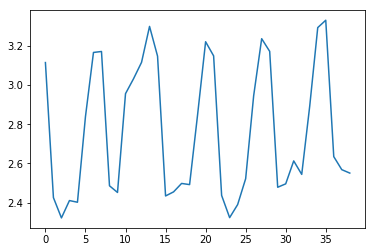

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.748661   
air_0164b9927d20bcc3_2017-04-23              1.355228   
air_0241aa3964b7f861_2017-04-23              2.391822   
air_0328696196e46f18_2017-04-23              2.143822   
air_034a3d5b40d5b1b1_2017-04-23              3.542860   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.746901  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.877645  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.933393  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.531984  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  33.565636

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/l5_3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')